Libraries & Reading the Data

In [72]:
import pandas as pd
import numpy as np
import statistics
import regex as re
from scipy import stats

import nltk
from nltk.util import ngrams
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

# Download NLTK stopwords if not already
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\szyma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("data/All_Streaming_Shows.csv")

In [4]:
data.head()

,Series Title,Year Released,Content Rating,IMDB Rating,R Rating,Genre,Description,No of Seasons,Streaming Platform
0,Breaking Bad,2008,18+,9.5,100,"Crime,Drama","When Walter White, a New Mexico chemistry teac...",5Seasons,Netflix
1,Game of Thrones,2011,18+,9.3,99,"Action & Adventure,Drama",Seven noble families fight for control of the ...,8Seasons,"HBO MAX,HBO"
2,Rick and Morty,2013,18+,9.2,97,"Animation,Comedy",Rick is a mentally-unbalanced but scientifical...,4Seasons,"Free Services,HBO MAX,Hulu"
3,Stranger Things,2016,16+,8.8,96,"Drama,Fantasy","When a young boy vanishes, a small town uncove...",3Seasons,Netflix
4,The Boys,2019,18+,8.7,95,"Action & Adventure,Comedy",A group of vigilantes known informally as “The...,2Seasons,Prime Video


Data Preparation

In [5]:
data.describe(include=object)

,Series Title,Content Rating,Genre,Description,No of Seasons,Streaming Platform
count,12353,7232,12353,12353,12353,10370
unique,12109,5,858,11875,94,530
top,Kingdom,16+,-1,-1,1Season,Netflix
freq,4,2581,479,479,5204,1427


In [6]:
# IMDB Rating & R Rating are already numeric variables, so there is no need to change their type
data.dtypes

Series Title           object
Year Released           int64
Content Rating         object
IMDB Rating           float64
R Rating                int64
Genre                  object
Description            object
No of Seasons          object
Streaming Platform     object
dtype: object

In [7]:
# There are multiple missing values in Content Rating and IMDB Rating
# There are some weird values in R Rating and Genre columns ("-1")
empty_data=data.isnull().any(axis=1)
null_rows=data[empty_data]
print(null_rows)

                            Series Title  Year Released Content Rating  \
186                               Castle           2009            16+   
250                             Gomorrah           2014            18+   
337                       Masters of Sex           2013            18+   
345                                Louie           2010            18+   
350                            Continuum           2012            16+   
...                                  ...            ...            ...   
12348  A Fishing Story with Ronnie Green           2017            NaN   
12349                  CMT Most Shocking           2003            NaN   
12350   NHL Road to the Outdoor Classics           2016            NaN   
12351                         Addy Media           2018            NaN   
12352             My Dream Derelict Home           2014            NaN   

       IMDB Rating  R Rating                     Genre  \
186            8.1        83              Comedy,Crim

In [8]:
data['R Rating'].unique()

array([100,  99,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,
        86,  85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,
        73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,
        60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,  48,
        47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,
        34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,
        21,  20,  19,  18,  17,  16,  15,  13,  10,  -1], dtype=int64)

In [9]:
# We have 9371 rows with normal values
len(data[(data["Genre"]!="-1") & (data["R Rating"]!=-1) & (data["Description"]!="-1") & (data["Streaming Platform"])])


9371

In [10]:
# We filter out "-1" values from the dataset
data=data[(data["Genre"]!="-1") & (data["R Rating"]!=-1) & (data["Description"]!="-1") & (data["Streaming Platform"])]

In [11]:
# We replace empty values in "IMDB Rating" with their mode values based on the R Rating score
data["IMDB Rating"]=data.groupby("R Rating")["IMDB Rating"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

In [12]:
# We drop NaN values from "IMDB Rating"
data.dropna(subset=["IMDB Rating"], inplace=True)

In [13]:
data["Genre"].unique()

array(['Crime,Drama', 'Action & Adventure,Drama', 'Animation,Comedy',
       'Drama,Fantasy', 'Action & Adventure,Comedy', 'Drama,History',
       'Action & Adventure,Crime', 'Action & Adventure,Animation',
       'Comedy,Romance', 'Comedy,2005', 'Comedy,Crime',
       'Action & Adventure,Anime', 'Drama,Science-Fiction',
       'Drama,Mystery', 'Fantasy,Crime', 'Thriller,Action & Adventure',
       'Drama,Thriller', 'Action & Adventure,Science-Fiction',
       'Drama,Horror', 'Comedy,LGBTQ', 'Comedy,2009', 'Drama,2007',
       'Comedy,Drama', 'Drama,Comedy', 'Documentary,Biography',
       'Comedy,Stand-up & Talk', 'Horror,Drama',
       'Drama,Action & Adventure', 'Drama,Romance', 'Drama,Sport',
       'Thriller,Biography', 'Science-Fiction,Animation', 'Comedy,2003',
       'Action & Adventure,Thriller', 'Thriller,LGBTQ', 'Comedy,2014',
       'Drama,2018', 'Drama,LGBTQ', 'Drama,Crime',
       'Action & Adventure,Fantasy', 'Comedy,2000', 'Biography,Drama',
       'Action & Adventure,H

In [14]:
# We make a set of unique streaming platforms
all_platforms=[]
for i in data["Streaming Platform"]:
    a=i.split(",")
    all_platforms.extend(a)

all_platforms=set(all_platforms)
print(all_platforms)


{'CNBC', 'FYI', 'TLC', 'Cartoon Network', 'History', 'NatGeo', 'Peacock Premium', 'BET+', 'DC Universe', 'FX', 'Starz', 'IndieFlix', 'ABC', 'NBC', 'Funimation', 'Disney', 'Free Services', 'A&E', 'BritBox', 'Apple TV+', 'HGTV', 'Netflix', 'TNT', 'Hallmark Movies Now', 'Adult Swim', 'Prime Video', 'Viceland', 'Cinemax', 'Hulu', 'Hallmark', 'Showtime', 'Travel Channel', 'USA', 'Syfy', 'TruTV', 'TVLand', 'YouTube Premium', 'HBO MAX', 'MTV', 'AMC Premiere', 'TBS', 'HBO', 'IFC', 'Hoopla', 'CBS All Access', 'Epix', 'Sundance', 'DIY', 'BET', 'Food Network', 'Bravo', 'FOX', 'Comedy Central', 'fuboTV', 'Nick', 'VH1', 'Science', 'Lifetime', 'AMC', 'BBC America', 'AcornTV', 'Crunchyroll', 'Shudder', 'Disney+'}


In [15]:
# Cleaning "Genre" column & creating dummy variables to replace different genres
for i in all_platforms:
    data["Genre"]=data["Genre"].str.replace(i,"")

data["Genre"]=data["Genre"].str.replace(r'\b\d{4}\b', '', regex=True)
data["Genre"]=data["Genre"].str.replace(r'\+', '', regex=True)
data["Genre"]=data["Genre"].apply(lambda x:"Unknown" if x=="-1" else x)
data["Genre"]=data["Genre"].str.replace(r'^,|(?<=,),$|,$', '', regex=True)
data["Genre"]=data["Genre"].str.strip()
data["Genre"]=data["Genre"].apply(lambda x:"Unknown" if x.strip()=="" else x)

data = data.join(
    data["Genre"].str.get_dummies(sep=',')
)

data=data.drop(columns=["Genre"])
data.head()

C:\Users\szyma\AppData\Local\Temp\ipykernel_13708\353383341.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data["Genre"]=data["Genre"].str.replace(i,"")


,Series Title,Year Released,Content Rating,IMDB Rating,R Rating,Description,No of Seasons,Streaming Platform,-Fiction,Action & Adventure,...,LGBTQ,Musical,Mystery,Reality,Romance,Sport,Stand-up & Talk,Thriller,Travel,Unknown
0,Breaking Bad,2008,18+,9.5,100,"When Walter White, a New Mexico chemistry teac...",5Seasons,Netflix,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Game of Thrones,2011,18+,9.3,99,Seven noble families fight for control of the ...,8Seasons,"HBO MAX,HBO",0,1,...,0,0,0,0,0,0,0,0,0,0
2,Rick and Morty,2013,18+,9.2,97,Rick is a mentally-unbalanced but scientifical...,4Seasons,"Free Services,HBO MAX,Hulu",0,0,...,0,0,0,0,0,0,0,0,0,0
3,Stranger Things,2016,16+,8.8,96,"When a young boy vanishes, a small town uncove...",3Seasons,Netflix,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Boys,2019,18+,8.7,95,A group of vigilantes known informally as “The...,2Seasons,Prime Video,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Content Rating variable
data["Content Rating"].unique()

array(['18+', '16+', '7+', 'all', nan, '13+'], dtype=object)

In [17]:
data["Content Rating"]=data["Content Rating"].str.replace("+", "")
data["Content Rating"]=data["Content Rating"]=data["Content Rating"].transform(lambda x: x.fillna("0"))
data["Content Rating"]=data["Content Rating"].str.replace("all", "0")
data["Content Rating"]=data["Content Rating"].apply(lambda x:"R Rated" if x=="18" else "Not R Rated")

C:\Users\szyma\AppData\Local\Temp\ipykernel_13708\4112547961.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["Content Rating"]=data["Content Rating"].str.replace("+", "")


In [18]:
dummies=pd.get_dummies(data["Content Rating"])
data=pd.concat([data, pd.get_dummies(data["Content Rating"], prefix="Content_Rating")], axis=1)
list(data.columns.values)

['Series Title',
 'Year Released',
 'Content Rating',
 'IMDB Rating',
 'R Rating',
 'Description',
 'No of Seasons',
 'Streaming Platform',
 '-Fiction',
 'Action & Adventure',
 'Animation',
 'Anime',
 'Biography',
 'Children',
 'Comedy',
 'Crime',
 'Cult',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Food',
 'Game Show',
 'Home & Garden',
 'Horror',
 'LGBTQ',
 'Musical',
 'Mystery',
 'Reality',
 'Romance',
 'Sport',
 'Stand-up & Talk',
 'Thriller',
 'Travel',
 'Unknown',
 'Content_Rating_Not R Rated',
 'Content_Rating_R Rated']

In [19]:
# Seasons variable
# In the original script "-1" value was excluded at this point, but we don't have that value
data["No of Seasons"].unique()

array(['5Seasons', '8Seasons', '4Seasons', '3Seasons', '2Seasons',
       '1Season', '10Seasons', '9Seasons', '15 Seasons', '1 Season',
       '5 Seasons', '31 Seasons', '6Seasons', '6 Seasons', '7 Seasons',
       '23 Seasons', '7Seasons', '10 Seasons', '12Seasons', '11 Seasons',
       '14Seasons', '3 Seasons', '4 Seasons', '16 Seasons', '11Seasons',
       '2 Seasons', '9 Seasons', '8 Seasons', '24 Seasons', '19 Seasons',
       '18 Seasons', '17 Seasons', '12 Seasons', '21 Seasons',
       '16Seasons', '28 Seasons', '13Seasons', '29 Seasons', '45 Seasons',
       '21Seasons', '27 Seasons', '25 Seasons', '40 Seasons', '20Seasons',
       '14 Seasons', '51 Seasons', '13 Seasons', '15Seasons',
       '20 Seasons', '24Seasons', '62 Seasons', '35 Seasons',
       '44 Seasons', '18Seasons', '17Seasons', '75 Seasons', '54 Seasons',
       '27Seasons', '22 Seasons', '32Seasons', '187 Seasons', '31Seasons',
       '36 Seasons', '26 Seasons', '32 Seasons', '52 Seasons',
       '34 Seasons', 

In [20]:
data["No of Seasons"]=data["No of Seasons"].str.replace(r"\D", "", regex=True)
data["No of Seasons"]=pd.to_numeric(data["No of Seasons"])

In [21]:
data["No of Seasons"].unique()

array([  5,   8,   4,   3,   2,   1,  10,   9,  15,  31,   6,   7,  23,
        12,  11,  14,  16,  24,  19,  18,  17,  21,  28,  13,  29,  45,
        27,  25,  40,  20,  51,  62,  35,  44,  75,  54,  22,  32, 187,
        36,  26,  52,  34,  37,  77,  41,  42,  60,  33, 160,  38,  84,
        39,  43,  48,  71,  82,  57], dtype=int64)

In [22]:
# Streaming Platform
data["Streaming Platform"].unique()
data["Platform Count"]=data["Streaming Platform"].apply(lambda x: len(x.split(", ")))


In [23]:
# Spearman Correlation
# The correlation is small, we can keep both variables
correlation=stats.spearmanr(data["Reality"], data["Documentary"])
print(correlation)

SignificanceResult(statistic=0.09808792944352131, pvalue=2.9770847435335363e-20)


In [24]:
# Deleting duplicates
data=data.drop_duplicates()

In [25]:
# No empty values
data.isnull().values.any()

False

In [26]:
# Combine built-in and custom stop words
custom_stop_words = set([
    "movie", "about", "with", "will", "that", "leave", "episodes",
    "imdb", "season", "seasons", "hulu", "prime"
])
stop_words = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS).union(custom_stop_words)

In [27]:
# Clean and tokenize function
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

# N-gram extraction function
def extract_ngrams(df, n):
    all_ngrams = []

    for description in df['Description'].dropna():
        tokens = clean_and_tokenize(description)
        n_gram_list = ngrams(tokens, n)
        filtered = [
            ' '.join(gram) for gram in n_gram_list
            if all(word not in stop_words for word in gram)
        ]
        all_ngrams.extend(filtered)

    # Count frequency
    ngram_counts = Counter(all_ngrams)

    # Convert to DataFrame
    ngram_df = pd.DataFrame(ngram_counts.items(), columns=['ngram', 'count'])
    ngram_df = ngram_df.sort_values(by='count', ascending=False).reset_index(drop=True)

    return ngram_df

In [28]:
# Extract and count bigrams
bigrams = extract_ngrams(data, 2)
print("Most common bigrams:")
print(bigrams.head(10))

Most common bigrams:
                    ngram  count
0         audience rating   8291
1            rating votes   8257
2  streaming subscription   8220
3        average audience   5189
4      available purchase   5088
5                 air new   4703
6               plans air   4701
7           running plans   4701
8          longer running   4701
9            date episode   3940


In [29]:
# Extract and count trigrams
trigrams = extract_ngrams(data, 3)
print("\nMost common trigrams:")
print(trigrams.head(10))


Most common trigrams:
                       ngram  count
0      audience rating votes   8257
1    average audience rating   5189
2              plans air new   4701
3          running plans air   4701
4       longer running plans   4701
5     announced date episode   3940
6      airing announced date   3940
7       high audience rating   2867
8    better average audience   2836
9  available purchase itunes   2375


In [30]:
# Extract and count 4-grams
fourgrams = extract_ngrams(data, 4)
print("\nMost common 4-grams:")
print(fourgrams.head(10))


Most common 4-grams:
                            ngram  count
0   average audience rating votes   5167
1           running plans air new   4701
2        longer running plans air   4701
3   airing announced date episode   3940
4      high audience rating votes   2856
5  better average audience rating   2836
6        new high audience rating   1705
7              plans air new high   1705
8           air new high audience   1705
9          air new better average   1695


In [31]:
# Tokenize and filter
def tokenize_and_filter(text):
    words = word_tokenize(text.lower())
    filtered_words = [
        word for word in words
        if word.isalpha()
        and word not in stop_words
        and word not in custom_stop_words
    ]
    return filtered_words

# Apply tokenization
data['keywords'] = data['Description'].apply(tokenize_and_filter)

# If you want one word per row (like unnest_tokens)
df_keywords = data.explode('keywords')

In [32]:
word_frequencies = df_keywords['keywords'].value_counts().reset_index()
word_frequencies.columns = ['word', 'count']
print(word_frequencies.head(10))

           word  count
0     streaming  10774
1      audience   8351
2        rating   8305
3         votes   8260
4  subscription   8226
5           new   6356
6     featuring   6166
7       average   5241
8     available   5152
9      purchase   5104


In [33]:
# List of common phrases (0-indexed in Python)
common_phrases = [
    "true crime", "food network", "world war", "award winning",
    "serial killer", "emmy award", "featuring", "family", "love"
]

# Ensure Description is ASCII-only (similar to iconv)
data['Description'] = data['Description'].str.encode('ascii', errors='ignore').str.decode('ascii')

# Add new columns based on phrase matches (case-insensitive)
data['true_crime'] = data['Description'].str.contains(common_phrases[0], case=False, na=False).astype(int)
data['world_war'] = data['Description'].str.contains(common_phrases[2], case=False, na=False).astype(int)
data['award_winning'] = data['Description'].str.contains(common_phrases[3], case=False, na=False).astype(int)
data['serial_killer'] = data['Description'].str.contains(common_phrases[4], case=False, na=False).astype(int)
data['emmy_award'] = data['Description'].str.contains(common_phrases[5], case=False, na=False).astype(int)
data['featuring'] = data['Description'].str.contains(common_phrases[6], case=False, na=False).astype(int)
data['love'] = data['Description'].str.contains(common_phrases[8], case=False, na=False).astype(int)

print(data.columns)

# Ensure your columns are correctly formatted and renamed
data['R_Rating'] = pd.to_numeric(data['R Rating'], errors='coerce')
data['Genre_GameShow'] = data['Game Show']
data['Genre_Animation'] = data['Animation']
data['Genre_Children'] = data['Children']
data['Genre_Crime'] = data['Crime']
data['Genre_Drama'] = data['Drama']
data['Genre_Anime'] = data['Anime']
data['Genre_Comedy'] = data['Comedy']
data['Genre_Documentary'] = data['Documentary']
data['Genre_Reality'] = data['Reality']
data['Genre_Fiction'] = data['-Fiction']
data['Genre_ActionAdventure'] = data['Action & Adventure']
data['Genre_HomeGarden'] = data['Home & Garden']
data['Genre_StandupTalk'] = data['Stand-up & Talk']
data['R_Rated'] = 'R Rated'  # Placeholder, same as in R code

# Create ordinal IMDB rating by rounding and converting to categorical
data['ordinal_IMDBRating'] = pd.Categorical(data['IMDB Rating'].round().astype(int), ordered=True)


Index(['Series Title', 'Year Released', 'Content Rating', 'IMDB Rating',
       'R Rating', 'Description', 'No of Seasons', 'Streaming Platform',
       '-Fiction', 'Action & Adventure', 'Animation', 'Anime', 'Biography',
       'Children', 'Comedy', 'Crime', 'Cult', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Food', 'Game Show', 'Home & Garden', 'Horror', 'LGBTQ',
       'Musical', 'Mystery', 'Reality', 'Romance', 'Sport', 'Stand-up & Talk',
       'Thriller', 'Travel', 'Unknown', 'Content_Rating_Not R Rated',
       'Content_Rating_R Rated', 'Platform Count', 'keywords', 'true_crime',
       'world_war', 'award_winning', 'serial_killer', 'emmy_award',
       'featuring', 'love'],
      dtype='object')


In [34]:
# First ordered logit model
# Not including "Platform Count" as it has 0 variance.
exog_vars = [
    'R_Rating', 'No of Seasons', 'Genre_ActionAdventure',
    'Genre_Animation', 'Genre_Children', 'Genre_Crime',
    'Genre_Drama', 'Genre_Reality', 'Genre_Anime',
    'Genre_Comedy', 'Genre_Documentary',
    'featuring', 'love'
]

# If interaction between Genre_Animation * Genre_Children is needed
data['Anim_x_Children'] = data['Genre_Animation'] * data['Genre_Children']
exog_vars.append('Anim_x_Children')

# Define exogenous variables matrix and drop NA
X = data[exog_vars].dropna()
y = data.loc[X.index, 'ordinal_IMDBRating']

if 'const' in X.columns:
    X = X.drop(columns='const')

# Fit the model
model1 = OrderedModel(y, X, distr='logit')
ologit = model1.fit(method='bfgs')

# Summary
print(ologit.summary())

Optimization terminated successfully.
         Current function value: 1.364680
         Iterations: 94
         Function evaluations: 97
         Gradient evaluations: 97
                             OrderedModel Results                             
Dep. Variable:     ordinal_IMDBRating   Log-Likelihood:                -12002.
Model:                   OrderedModel   AIC:                         2.405e+04
Method:            Maximum Likelihood   BIC:                         2.421e+04
Date:                Fri, 09 May 2025                                         
Time:                        18:51:02                                         
No. Observations:                8795                                         
Df Residuals:                    8772                                         
Df Model:                          14                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [35]:
# Equivalent of Linear Hypothesis in R

# Get restricted parameters
hypotheses = ['No of Seasons = 0', 'Genre_Animation = 0', 'Genre_Crime = 0',
              'Genre_Drama = 0', 'love = 0', 'Anim_x_Children = 0', 'Genre_Anime = 0']

print(ologit.wald_test(hypotheses))

print(f"\n\nAIC cont_ratio: {ologit.aic}")
print(f"BIC cont_ratio: {ologit.bic}")

<Wald test (chi2): statistic=[[6.9151218]], p-value=0.437770604029607, df_denom=7>


AIC cont_ratio: 24050.713990361055
BIC cont_ratio: 24213.598579476


c:\Users\szyma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [36]:
# Reduced set of variables
exog_vars = [
    'R_Rating', 'Genre_ActionAdventure', 'Genre_Animation', 'Genre_Children',
    'Genre_Reality', 'Genre_Comedy', 'Genre_Documentary', 'featuring'
]

X2 = data[exog_vars].dropna()
y2 = data.loc[X2.index, 'ordinal_IMDBRating']

model2 = OrderedModel(y2, X2, distr='logit')
ologit_2 = model2.fit(method='bfgs')

# Summary
print(ologit_2.summary())

Optimization terminated successfully.
         Current function value: 1.364838
         Iterations: 87
         Function evaluations: 91
         Gradient evaluations: 91
                             OrderedModel Results                             
Dep. Variable:     ordinal_IMDBRating   Log-Likelihood:                -12004.
Model:                   OrderedModel   AIC:                         2.404e+04
Method:            Maximum Likelihood   BIC:                         2.416e+04
Date:                Fri, 09 May 2025                                         
Time:                        18:51:15                                         
No. Observations:                8795                                         
Df Residuals:                    8778                                         
Df Model:                           8                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [37]:
# Equivalent of anova(ologit, ologit_res) in R

# Likelihood ratio test
lr_stat = 2 * (ologit.llf - ologit_2.llf)  # Log-likelihoods
df_diff = ologit.df_model - ologit_2.df_model  # Degrees of freedom difference

#  Pulkrob's Chi-square Test (pulkrob.chisq()) in Python: computes 
# a Chi-square test for the likelihood ratio statistic, often used to 
# test the significance of a specific variable in a model.

p_value = stats.chi2.sf(lr_stat, df_diff) 

print(f"Likelihood Ratio Test Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-value: {p_value:.4f}")
print("H0 (null): The additional variables in the full model are " \
        "jointly insignificant.\n\nP-value < 0.05: Reject H0 → the extra " \
        "variables add significant information.\nP-value ≥ 0.05: Fail to " \
        "reject H0 → stick with the reduced model.")


print(f"\n\nAIC cont_ratio: {ologit_2.aic}")
print(f"BIC cont_ratio: {ologit_2.bic}")

Likelihood Ratio Test Statistic: 2.7779
Degrees of Freedom: 6
P-value: 0.8362
H0 (null): The additional variables in the full model are jointly insignificant.

P-value < 0.05: Reject H0 → the extra variables add significant information.
P-value ≥ 0.05: Fail to reject H0 → stick with the reduced model.


AIC cont_ratio: 24041.491900372566
BIC cont_ratio: 24161.884857544486


In [38]:
# Equivalent to coeftest in R

params = ologit_2.params
bse = ologit_2.bse
z_scores = params / bse
p_values = ologit_2.pvalues

coeftest_df = pd.DataFrame({
    "coef": params,
    "std_err": bse,
    "z": z_scores,
    "p_value": p_values
})

print(coeftest_df)

                           coef   std_err          z        p_value
R_Rating               0.083220  0.001831  45.454807   0.000000e+00
Genre_ActionAdventure -0.291593  0.056902  -5.124467   2.983800e-07
Genre_Animation       -0.107713  0.052933  -2.034878   4.186311e-02
Genre_Children        -0.423413  0.098992  -4.277259   1.892083e-05
Genre_Reality         -0.827006  0.064866 -12.749478   3.138412e-37
Genre_Comedy          -0.258957  0.051490  -5.029309   4.922507e-07
Genre_Documentary      1.083582  0.060122  18.023066   1.284252e-72
featuring             -0.491802  0.054314  -9.054851   1.367539e-19
1/2                   -1.999617  0.158247 -12.636083   1.335422e-36
2/3                   -0.976596  0.213231  -4.579986   4.650078e-06
3/4                   -0.043608  0.098408  -0.443130   6.576717e-01
4/5                   -0.149960  0.068411  -2.192027   2.837758e-02
5/6                    0.031452  0.041983   0.749173   4.537527e-01
6/7                    0.436195  0.022403  19.47

In [39]:
# There is no equivalent test in Python to 
# lipsitz.test(), brant(), logitgof() in R\

# Fit the ordinal logistic regression model (using 'probit' method)
model3 = OrderedModel(y, X, distr='probit')
probit = model3.fit(method='bfgs')

# Summary of the model
print(probit.summary())

Optimization terminated successfully.
         Current function value: 1.364786
         Iterations: 92
         Function evaluations: 97
         Gradient evaluations: 97
                             OrderedModel Results                             
Dep. Variable:     ordinal_IMDBRating   Log-Likelihood:                -12003.
Model:                   OrderedModel   AIC:                         2.405e+04
Method:            Maximum Likelihood   BIC:                         2.422e+04
Date:                Fri, 09 May 2025                                         
Time:                        18:51:38                                         
No. Observations:                8795                                         
Df Residuals:                    8772                                         
Df Model:                          14                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [40]:
# coeftest() 

print(probit.wald_test(hypotheses), '\n\n')

# vif()

# Extract features (X) for calculating VIF
X_vif = data[['R_Rating', 'Genre_ActionAdventure', 'Genre_Animation',
              'Genre_Children', 'Genre_Reality', 'Genre_Comedy', 
              'Genre_Documentary', 'featuring']]
# Add constant to the features
X_vif = sm.add_constant(X_vif)
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

print(f"\n\nAIC cont_ratio: {probit.aic}")
print(f"BIC cont_ratio: {probit.bic}")

<Wald test (chi2): statistic=[[8.88961234]], p-value=0.2606789306219323, df_denom=7> 


                 feature        VIF
0                  const  15.333633
1               R_Rating   1.526339
2  Genre_ActionAdventure   1.159194
3        Genre_Animation   1.191374
4         Genre_Children   1.092353
5          Genre_Reality   1.126008
6           Genre_Comedy   1.179282
7      Genre_Documentary   1.189969
8              featuring   1.558044


AIC cont_ratio: 24052.587750982166
BIC cont_ratio: 24215.472340097112


c:\Users\szyma\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [41]:
# In R, we're utilizing the VGAM package to fit an ordinal logistic regression model with the vglm() function and then assessing its goodness-of-fit
#  using the lipsitz() and hosmerlem() functions from the gofcat package. Unfortunately, we don't have equivalent built-in functions in Python.

# Since we are looking into reproducibility, we won't be adding other models - so we currently have a comparison of three different models.

ML Part

In [157]:
print(data.columns)

Index(['Series Title', 'Year Released', 'Content Rating', 'IMDB Rating',
       'R Rating', 'Description', 'No of Seasons', 'Streaming Platform',
       '-Fiction', 'Action & Adventure', 'Animation', 'Anime', 'Biography',
       'Children', 'Comedy', 'Crime', 'Cult', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Food', 'Game Show', 'Home & Garden', 'Horror', 'LGBTQ',
       'Musical', 'Mystery', 'Reality', 'Romance', 'Sport', 'Stand-up & Talk',
       'Thriller', 'Travel', 'Unknown', 'Content_Rating_Not R Rated',
       'Content_Rating_R Rated', 'Platform Count', 'keywords', 'true_crime',
       'world_war', 'award_winning', 'serial_killer', 'emmy_award',
       'featuring', 'love', 'R_Rating', 'Genre_GameShow', 'Genre_Animation',
       'Genre_Children', 'Genre_Crime', 'Genre_Drama', 'Genre_Anime',
       'Genre_Comedy', 'Genre_Documentary', 'Genre_Reality', 'Genre_Fiction',
       'Genre_ActionAdventure', 'Genre_HomeGarden', 'Genre_StandupTalk',
       'R_Rated', 'ordinal_IMDB

In [163]:
columns_to_exclude = ['Series Title', 'R Rating', 'Description', 
                      'Streaming Platform', 'Content Rating', 
                      'keywords', 'ordinal_IMDBRating', 'Content_Rating_R Rated',
                      'Content_Rating_Not R Rated', 'Anim_x_Children',  'Game Show', 'Animation', 
                      'Children', 'Crime', 'Drama', 'Anime', 'Comedy', 'Documentary', 'Reality', 
                      '-Fiction', 'Action & Adventure', 'Home & Garden', 'Stand-up & Talk', 'R_Rated']

df_model = data.drop(columns=columns_to_exclude)

print(df_model.columns)

Index(['Year Released', 'IMDB Rating', 'No of Seasons', 'Biography', 'Cult',
       'Family', 'Fantasy', 'Food', 'Horror', 'LGBTQ', 'Musical', 'Mystery',
       'Romance', 'Sport', 'Thriller', 'Travel', 'Unknown', 'Platform Count',
       'true_crime', 'world_war', 'award_winning', 'serial_killer',
       'emmy_award', 'featuring', 'love', 'R_Rating', 'Genre_GameShow',
       'Genre_Animation', 'Genre_Children', 'Genre_Crime', 'Genre_Drama',
       'Genre_Anime', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Reality',
       'Genre_Fiction', 'Genre_ActionAdventure', 'Genre_HomeGarden',
       'Genre_StandupTalk'],
      dtype='object')


In [164]:
df_model.head()

,Year Released,IMDB Rating,No of Seasons,Biography,Cult,Family,Fantasy,Food,Horror,LGBTQ,Musical,Mystery,Romance,Sport,Thriller,Travel,Unknown,Platform Count,true_crime,world_war,award_winning,serial_killer,emmy_award,featuring,love,R_Rating,Genre_GameShow,Genre_Animation,Genre_Children,Genre_Crime,Genre_Drama,Genre_Anime,Genre_Comedy,Genre_Documentary,Genre_Reality,Genre_Fiction,Genre_ActionAdventure,Genre_HomeGarden,Genre_StandupTalk
0,2008,9.5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,100,0,0,0,1,1,0,0,0,0,0,0,0,0
1,2011,9.3,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,99,0,0,0,0,1,0,0,0,0,0,1,0,0
2,2013,9.2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,97,0,1,0,0,0,0,1,0,0,0,0,0,0
3,2016,8.8,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,96,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2019,8.7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,95,0,0,0,0,0,0,1,0,0,0,1,0,0


In [165]:
X = df_model.drop(columns='IMDB Rating')
y = df_model['IMDB Rating']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Random Forest

In [168]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=123)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [169]:
print("Random Forest R²:", round(r2_score(y_test, rf_preds), 3))
print("Random Forest MAPE:", round(mean_absolute_percentage_error(y_test, rf_preds) * 100, 2))

Random Forest R²: 0.354
Random Forest MAPE: 11.43


In [170]:
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

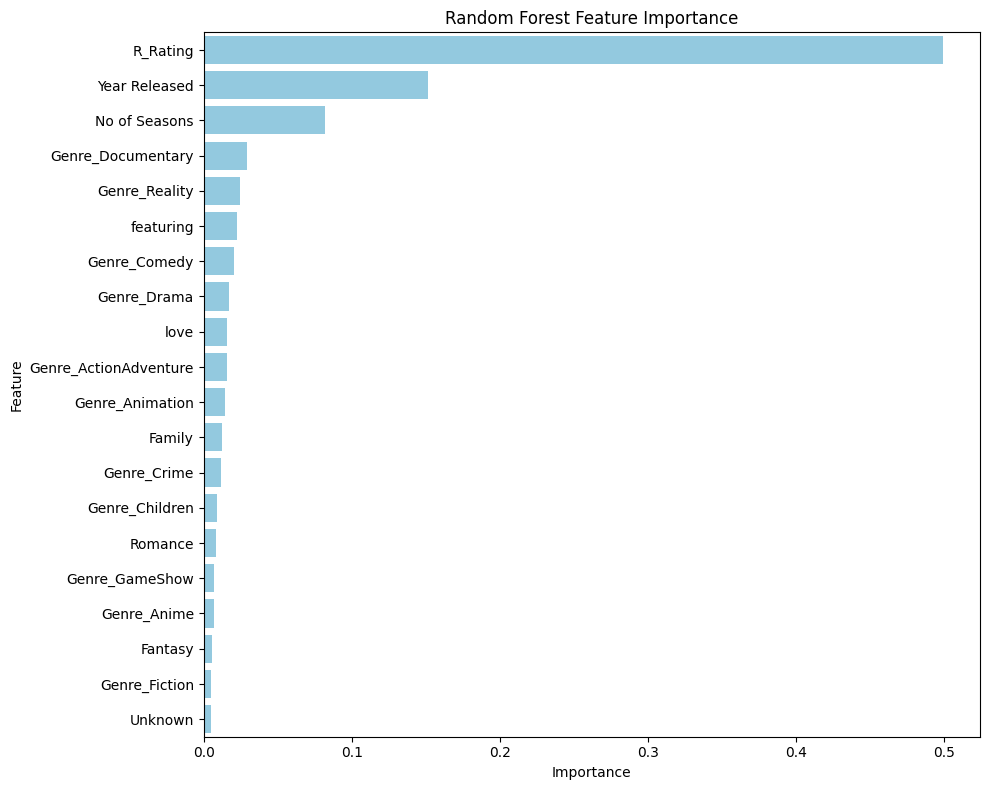

In [171]:
plt.figure(figsize=(10, 8))
sns.barplot(data=rf_importances.head(20), x='Importance', y='Feature', color='skyblue')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

XGBoost

In [172]:
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=123)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [173]:
print("XGBoost R²:", round(r2_score(y_test, xgb_preds), 3))
print("XGBoost MAPE:", round(mean_absolute_percentage_error(y_test, xgb_preds) * 100, 2))

XGBoost R²: 0.403
XGBoost MAPE: 11.11


<Figure size 1000x800 with 0 Axes>

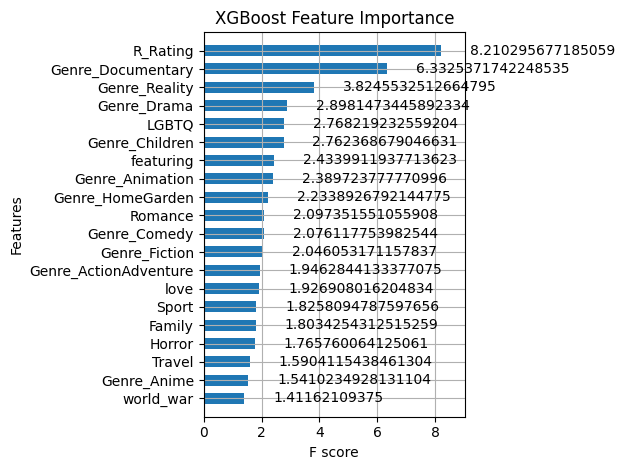

In [174]:
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.6)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()